# **CIS 5200: Machine Learning**

## **Explaining Machine Learning Models** 

- **Worksheet Creator:** Utkarsh Kashyap
- **Content Reviewers:** Lyle Ungar, Andy Liu
- **Objectives:** This worksheet will work through an example of analysing feature importance. We will do this mainly using Shapley Values ("SHAP").


## Initialize Penn Grader

In [1]:
%%capture
!pip install penngrader

In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os 
import sys

In [3]:
# For autograder only, do not modify this cell. 
# True for Google Colab, False for autograder
NOTEBOOK = (os.getenv('IS_AUTOGRADER') is None)
if NOTEBOOK:
    print("[INFO, OK] Google Colab.")
else:
    print("[INFO, OK] Autograder.")
    sys.exit()

[INFO, OK] Google Colab.


In [4]:
#PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY. IF NOT, THE AUTOGRADER WON'T KNOW WHO 
#TO ASSIGN POINTS TO YOU IN OUR BACKEND
STUDENT_ID = 57931095 # YOUR PENN-ID GOES HERE AS AN INTEGER#

In [5]:
import penngrader.grader
grader = penngrader.grader.PennGrader(homework_id = 'CIS_5200_202230_HW_SHAP_WS', student_id = STUDENT_ID)

PennGrader initialized with Student ID: 57931095

Make sure this correct or we will not be able to store your grade


# **Data Preparation**

We will use the credit score dataset from UCI Classification tasks. Since this is not included in sklearn, we first need to download it. 

In [6]:
!pip install shap
!pip install --upgrade xlrd #For pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 3.3 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.2.0
    Uninstalling xlrd-1.2.0:
      Successfully uninstalled xlrd-1.2.0


In [7]:
import requests
import xgboost 
import shap 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression, load_boston
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from random import random
from random import seed

You only need to run this block once per instance. 

In [8]:
credit_dataset_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
request = requests.get(credit_dataset_url, allow_redirects=True)

with open('credit_data.xls', 'wb') as data_file: 
  data_file.write(request.content)


Load the data into a sklearn-compatible format! 

Note that for the purpose of this worksheet, we are simplifying this dataset to only contain the features: 

- LIMIT_BAL: Limit balance of the person: Real valued int
- SEX: Gender: 1 = Male; 2 = Female
- MARRIAGE: 1 = Married; 2 = Single; 3 = Other.
- EDUCATION: 1 = Graduate School; 2 = University; 3 = High School; 4 = Others
- AGE: Age - real valued int

The target variable to be predicted is:

- Default on payment next month: 0 - no default; 1 - default 

This is done to simplify the interpretations of the worksheet. 

You can check out the full dataset [here](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients). 

In [9]:
num_samples = 1000

df_pandas = pd.read_excel('credit_data.xls')
cols_to_drop = [i for i in range(0, 25) if i not in [1, 2, 3, 4, 5, 24]]
df_pandas.drop(df_pandas.columns[cols_to_drop], axis = 1, inplace=True)
new_headers = df_pandas.iloc[0, :]

df_pandas = df_pandas.iloc[1:, :]
df_pandas.columns = new_headers

df = df_pandas.to_numpy()

train_labels = [name for name in new_headers]
train_X_labels = train_labels[:len(train_labels) - 1]
y_label = train_labels[-1]

X, y = df_pandas.iloc[:num_samples,:len(df[0]) - 1], df_pandas.iloc[:num_samples, len(df[0]) - 1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 21)

print("Sample data point: ")
print(X_train.iloc[0])

Sample data point: 
0
LIMIT_BAL    130000
SEX               1
EDUCATION         2
MARRIAGE          2
AGE              38
Name: 109, dtype: object


Let's train a RandomForestClassifier on this data! Because this is a tree based algorithm, we do not need to standardize or normalize the data.  

In [10]:
forest = RandomForestClassifier(random_state=42)
forest.fit(X_train, y_train.tolist())

y_pred = forest.predict(X_test)
print(f"Classification accuracy on the test set is {(1 - np.abs(y_test - y_pred).mean()) * 100}")

Classification accuracy on the test set is 72.0


We get an accuracy of ~72% on the test set. Let's now try to see which features our most important to our Random forest model. 

##Feature Importance

We will first use sklearn's provided method calls inside RandomForestClassifier to look at the feature importances. 

The first one is impurity based importance. Sometimes called “gini importance” or “mean decrease impurity”, it is defined as the total decrease in node impurity (weighted by the probability of reaching that node (which is approximated by the proportion of samples reaching that node)) averaged over all trees of the ensemble.

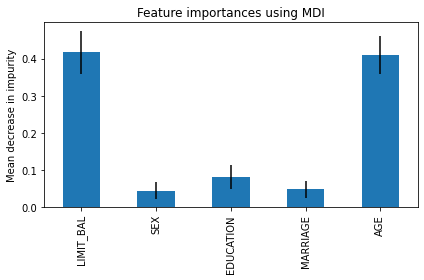

In [11]:
feature_importances_rf = forest.feature_importances_
forest_importances = pd.Series(feature_importances_rf, index=train_X_labels)
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Next we try the permutation importance. The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled. 

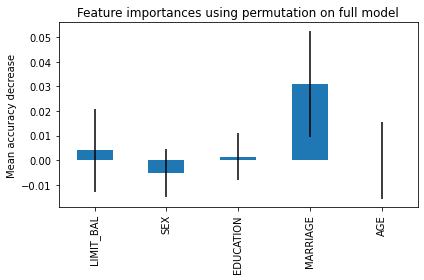

In [12]:
result = permutation_importance(
    forest, X_test, y_test.tolist(), n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=train_X_labels)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()


##**Interpretations and pitfalls of importance measures**

We have 2 plots of importance that tell wildly different stories. The impurity based feature importance analysis tells us that LIMIT_BAL and AGE are the most important features, and are almost equally important, while the other factors aren't as important. (Note that this could also be because the data is unnormalized). 

The second plot, which is permutation based importance tells us that marriage is perhaps the most important factor.

Moreover, the granularity is not always enough. Sometimes we want to investigate which features played a role in an individual prediction, and not just the entire dataset. 

Given that such contradictory results appear in a lot of models, two requirements have been defined: 

- Consistency. Whenever we change a model such that it relies more on a feature, then the attributed importance for that feature should not decrease.

- Accuracy. The sum of all the feature importances should sum up to the total importance of the model. (For example if importance is measured by the R² value then the attribution to each feature should sum to the R² of the full model)

##**Shapley Values**

Each feature in a data point contributes to the prediction for that point. Shapley values are a popular way of measuring their contributions.

Scott Lundberg started the package [SHAP](https://github.com/slundberg/shap) which calculates and visualizes Shapley values of a learnt model. 

Let's dive in! 

In [13]:
# Initialize an explainer object to "explain" our random forest model 
explainer = shap.TreeExplainer(forest)
print(f"Expected value for class 0 (make payment): {explainer.expected_value[0]}, class 1 (default on payment): {explainer.expected_value[1]}")

Expected value for class 0 (make payment): 0.7918625, class 1 (default on payment): 0.20813750000000003


Let's now pick a single data point and see the features contributing to its prediction. 

In [23]:
shap.initjs()

observation = X_train.iloc[5]
print(f"Label: {y_train.iloc[5]}")
shap_values = explainer.shap_values(observation)
shap.force_plot(explainer.expected_value[0], shap_values[1], observation)


Label: 1


There are 2 classes for this prediction task, 0 and 1. 0 means that a person does not default on their credit card payment, 1 means that they do. 

In the plot above, we picked a point and saw that for class 0, the computed function value is 0.94, as compared to the base value for class 0 which is 0.79, meaning that this prediction should belong to class 0. 

Moreover, we also see that the factors contributing the most to this prediction are the age and sex of the person. 

In a practical scenario, especially those which have a decision and cost associated with them, it is always handy to know why a model predicts something rather than just relying on blackbox accuracy or any other performance score. 

## *Section 1*

Answer the following questions: 

From the graph, what desired property (accuracy/consistency) do you think is being satisfied?

In [15]:
desired_prop = "consistency"
grader.grade(test_case_id='desired_prop', answer=desired_prop)

Correct! You earned 1.0/1.0 points. You are a star!

Your submission has been successfully recorded in the gradebook.


shap_values[1] contains the shapley values for class 1. Replace shap_values[0] by shap_values[1] and report what you find. 

In [17]:
inv_shap_finding = "lower"
grader.grade(test_case_id='inv_shap_finding', answer=inv_shap_finding)

Correct! You earned 1.0/1.0 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Are the findings above justified? Explain briefly why or why not. 

In [18]:
finding_justification = "Yes. The findings are justified."
grader.grade(test_case_id='finding_justification', answer=finding_justification)

Correct! You earned 1.0/1.0 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In the example above, we visualized the Shapley values for the first person. Repeat the same thing for the 6th person in the set. What are the dominant factors contributing to this prediction?

In [24]:
dom_fac_sixth_point = "Marriage"
grader.grade(test_case_id='dom_fac_sixth_point', answer=dom_fac_sixth_point)

Correct! You earned 1.0/1.0 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Now that we have looked at per-point predictions and contributors, lets aggregate 1000 points and see the dominant factors overall. 

In [27]:
shap.initjs()
shap_values = explainer.shap_values(X_train.iloc[:num_samples])
shap.force_plot(explainer.expected_value[1], np.array(shap_values)[1], X_train[:num_samples])


Notice that there are 2 drop-downs, one on the left side of the y-axis, and one above the graph. 

The drop-down above the graph is set to "order samples by similarity" which means that samples are ordered based on their similarity with each other. 

- On the x-axis, we have the progression of samples from 0 to 1000.  
- On the y-axis, we currently have f(x), which means the output value for class. 
- Notice that if you hover over any part of the graph, in red you will see the field name that is pushing the value of f(x) upward, and in blue you'll see the features that are pushing f(x) downward. 


We can play around with this graph to get some more insight, let's see how🇰

- Keep the drop down above the graph same as before (set to "sample order by similarity"). 
- Change the selected options in the left-hand dropdown. You should see 5 other options other than f(x). Each option visualizes the effect of one particular feature on the prediction. Remember that because we are plotting shap_values[0], red values mean that the feature contributes to the likelihood of getting a prediction of 0, while blue feature values contribute to the likelihood of getting a prediction of 1. 

##**Section 2**

Play around with the other 5 options in the left-side dropdown and answer the following questions: 

What happens if you create the same graph but using explainer.expected_value[1] and shap_values[1]? Compare any one field like 'AGE effect' and report your findings briefly. 

In [28]:
bulk_invert_finding = "More values are above the mean"
grader.grade(test_case_id='bulk_invert_finding', answer=bulk_invert_finding)

Correct! You earned 1.0/1.0 points. You are a star!

Your submission has been successfully recorded in the gradebook.



The samples are ordered by similarity. Based on the graphs that you saw for the 5 feature effects, which feature according to you has the most effect overall on the predictions according to our random forest model? Why? 

In [33]:
most_dominant_feature_student = "Age"
grader.grade(test_case_id='most_dominant_feature_student', answer=most_dominant_feature_student)

Correct! You earned 1.0/1.0 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Let's build a summary plot to see what the most dominant features are overall. 

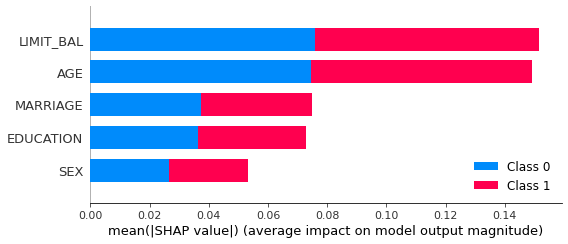

In [30]:
shap.summary_plot(shap_values, X_train.iloc[0:num_samples], plot_type="bar")

Our SHAP values are of the shape (num_classes, num_points, num_features). A value $(c_A, p_m, f_k)$ corresponds to the contribution of feature $f_k$ to the log prob of prediction of class $c_A$ for the point $p_m$. 

If you want to calculate the overall importance of feature for the whole dataset, just take the mean of absolute value of feature SHAP values over all the training points. 

SHAP($f_k$) = $\dfrac {1}{|X|} \sum_X | f_k | $

Let's calculate them through code. 

In [32]:
vals = np.mean(np.abs(np.array(shap_values)[0]), axis = 0)

for label, val in zip(train_X_labels, vals):
  print(f"SHAP value for {label} is {val}")

SHAP value for LIMIT_BAL is 0.0757930946200298
SHAP value for SEX is 0.026635034700942438
SHAP value for EDUCATION is 0.036436933844205925
SHAP value for MARRIAGE is 0.03749922948482035
SHAP value for AGE is 0.07461390693633596


According to the summary plot, which is the most important feature? 

In [34]:
most_important_feature_plot = "Limit_Bal"
grader.grade(test_case_id='most_important_feature_plot', answer=most_important_feature_plot)

Correct! You earned 1.0/1.0 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#**Correlation between features** 

In most real world datasets, many features  are correlated. In a housing dataset, the size of the house a person owns will be strictly tied to the size of the house. Both of these factors will also be closely related to the annual income of the person, which could be closely related to their annual taxes. 

Therefore, it is important to understand these correlations and causality in our dataset, which helps us better explain our models and our prediction. 

Let's see what SHAP provides for correlated features. 

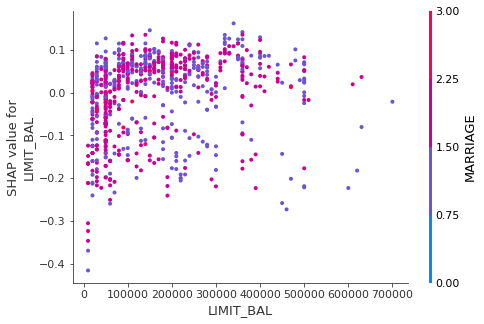

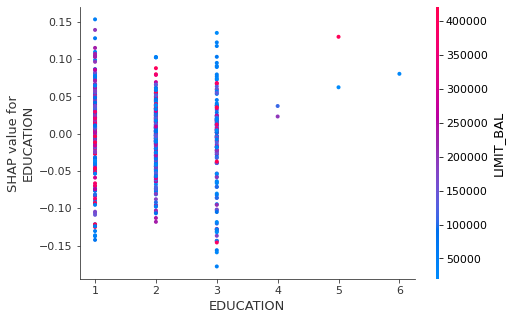

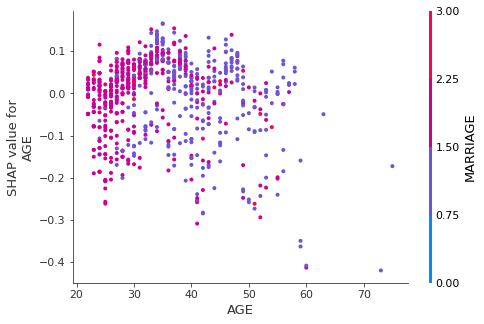

In [35]:
for name in X_train.columns:
    if name == 'MARRIAGE' or name == 'SEX': 
      continue
    shap.dependence_plot(name, shap_values[0], X_train, display_features=X_train)


For ease of interpretation, let's rewrite the codes here🇰

- Marriage: 1 = Married; 2 = Single; 3 = Other. 
- Education: 1 = Graduate School; 2 = University; 3 = High School; 4 = Others

Let's study the first graph, LIMIT_BAL vs MARRIAGE. 

- The vertical line at any X (LIMIT_BAL) value shows us the total dispersion of SHAP values of the feature at that feature value. In other words, it shows how much does the feature impact observations at this value. 
- At lower values of LIMIT_BAL, the vertical line spans a lot, meaning that lower values of LIMIT_BAL can have both a positive or a negative effect in terms outcome probability of class 0. 
- At higher value of LIMIT_BAL, it seems to be less frequent in the bottom region, meaning that as LIMIT_BAL increases, it tends to have a positive effect on probability of predicting class 0 (not defaulting). 
- Based on the coloring of dots, we can see that there isn't much correlation between LIMIT_BAL and MARRIAGE. 



## *Section 3*

Now that you have learnt how to interpret these graphs, answer the following: 

What conclusion can you draw from AGE vs MARRIAGE graph? Does it seem intuitive? 

In [36]:
age_v_marriage = "There are more married people above age 30 than single people. Yes it seems intuitive as it reflects the genereal trend among people as people eventually find a life partner and settle down."
grader.grade(test_case_id='age_v_marriage', answer=age_v_marriage)

Correct! You earned 1.0/1.0 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# Submitting to the Autograder


Now go to the File menu and choose "Download .ipynb".  Go to [Gradescope](https://www.gradescope.com/courses/409970) and:

1. From "File" --> Download both .ipynb and .py files
1. Name these files `SHAP_WS.ipynb` and `SHAP_WS.py` respectively
1. Sign in using your Penn email address (if you are a SEAS student we recommend using the Google login) and ensure  your class is "CIS 5200"
1. Select **Worksheet: SHAP**
1. Upload both files
1. PLEASE CHECK THE AUTOGRADER OUTPUT TO ENSURE YOUR SUBMISSION IS PROCESSED CORRECTLY!

You should be set! Note that this assignment has 8 autograded points that will show up upon submission. Points are awarded based on a combination of correctness and sufficient effort.